In [424]:
# 🐍 Install helper libs when running on Colab/Binder
#!pip install automata-lib pyformlang graphviz

from dataclasses import dataclass
from typing import Set, Tuple, List
from copy import deepcopy

In [425]:
@dataclass(frozen=True)
class Rule:
    lhs: Tuple[str, ...]   # (a,) or (a,b)
    rhs: Tuple[str, ...]   # always a single-letter RHS here

@dataclass
class Grammar:
    name: str
    alphabet: Set[str]
    rules: List[Rule]

    # duplicating / non-duplicating letters
    @property
    def Sigma_d(self) -> Set[str]:
        return {r.lhs[0] for r in self.rules if len(r.lhs)==1 and r.rhs==(r.lhs[0], r.lhs[0])}

    @property
    def Sigma_n(self) -> Set[str]:
        return self.alphabet - self.Sigma_d

    def binary_rules(self):
        return [r for r in self.rules if len(r.lhs)==2]

In [426]:
def basic_interface(A: Set[str], B: Set[str], G: Grammar) -> Set[str]:
    """Return {z | ∃ x∈A, y∈B, xy→z ∈ R}."""
    out = set()
    for rule in G.binary_rules():
        x, y = rule.lhs
        (z,) = rule.rhs
        if x in A and y in B:
            out.add(z)
    return out

## Examples  

In [427]:
G1 = Grammar(
    name='G1',
    alphabet={'a','b','c','d','e','f','g'},
    rules=[
        Rule(('a',), ('a','a')),
        Rule(('b',), ('b','b')),
        Rule(('c',), ('c','c')),
        Rule(('g',), ('g','g')),
        Rule(('a','b'), ('c',)),
        Rule(('a','b'), ('g',)),
        Rule(('c','b'), ('a',)),
        Rule(('c','b'), ('d',)),
        Rule(('c','a'), ('e',)),
        Rule(('e','d'), ('f',)),
    ]
)

G2= Grammar(
    name='G2',
    alphabet={'a','b','c'},
    rules=[
        Rule(('a',), ('a','a')),
        Rule(('b',), ('b','b')),
        Rule(('c',), ('c','c')),
        Rule(('a','b'), ('c',)),
        Rule(('a','c'), ('b',))
    ]
)


In [428]:
# ──────────────────────────────────────────────────────────────
#  Tree nodes  +  next-relation
# ──────────────────────────────────────────────────────────────
from dataclasses import dataclass, field
from typing import List, Dict, Set, Tuple, FrozenSet

@dataclass
class TreeNode:
    id: int
    A: FrozenSet[str]
    B: FrozenSet[str]
    parent: "TreeNode | None" = None        # ▼ needed to test right-desc
    is_right: bool = False                  # ▼ was this edge a 'right' child?
    children: List["TreeNode"] = field(default_factory=list)
    next_nodes: Set["TreeNode"] = field(default_factory=set)
    back_edge: "TreeNode | None" = None

    def label(self) -> str:
        return f"({','.join(sorted(self.A))}|{','.join(sorted(self.B))})"
    def __hash__(self): return self.id

def is_right_desc(q: TreeNode, r: TreeNode) -> bool:
    """Return True iff r is in the subtree rooted at q.right_child."""
    cur = r
    while cur.parent is not None:           # climb towards root
        if cur.parent is q:
            return cur.is_right             # right child of q?
        cur = cur.parent
    return False

# ──────────────────────────────────────────────────────────────
#  Up-closure helper   a ↑
# ──────────────────────────────────────────────────────────────
def upward_closure(letter: str, G: Grammar) -> Set[str]:
    """Compute a↑ = closure of {letter} under binary rules."""
    if letter not in G.Sigma_d:
        return {letter}

    closure = {letter}
    changed = True
    while changed:
        changed = False
        for rule in G.binary_rules():
            x, y = rule.lhs
            (z,) = rule.rhs          # one-letter RHS in this grammar
            if x in closure and y in closure and z not in closure:
                closure.add(z)
                changed = True
    return closure

# ──────────────────────────────────────────────────────────────
#  Main builder
# ──────────────────────────────────────────────────────────────
def build_tree(
    G: Grammar,
    s1: str,
    s2: str,
    interfaces_seed: dict[Tuple[FrozenSet, FrozenSet], set[str]] | None = None,
):
    """
    Build the parsing tree given *existing* interface information.

    interfaces_seed  – mapping (A↑,B↑) ➔ already-known I(A,B)
                       (may be empty). New basic interfaces are unioned in.
    """
    if interfaces_seed is None:
        interfaces_seed = {}

    nodes: list[TreeNode] = []
    first_occ: dict[tuple[FrozenSet, FrozenSet], TreeNode] = {}
    interfaces: dict[tuple[FrozenSet, FrozenSet], set[str]] = deepcopy(interfaces_seed)
    duplicates: list[tuple[TreeNode, TreeNode]] = []

    nid = 0
    def new_node(A: FrozenSet[str], B: FrozenSet[str],
                 parent, is_right) -> TreeNode:
        nonlocal nid
        n = TreeNode(id=nid, A=A, B=B, parent=parent, is_right=is_right)
        nid += 1
        nodes.append(n)

        lbl = (A, B)
        # merge basic interface with any seed info
        if lbl not in interfaces:
            interfaces[lbl] = set()
        interfaces[lbl] |= basic_interface(A, B, G)   # union

        if lbl not in first_occ:
            first_occ[lbl] = n
        return n

    # root
    A0 = frozenset(upward_closure(s1, G))
    B0 = frozenset(upward_closure(s2, G))
    root = new_node(A0, B0, None, False)

    # DFS stack: (node, ancestor-label-set)
    stack: List[Tuple[TreeNode, Set[Tuple[FrozenSet, FrozenSet]]]] = [(root, set())]

    while stack:
        cur, ancestors = stack.pop()
        lbl = (cur.A, cur.B)

        # --- duplicate label  -----------------------------------------
        if lbl in ancestors:
            anc = first_occ[lbl]
            cur.back_edge = anc
            duplicates.append((cur, anc))           # ▼ remember for final pass
            continue                                # no children

        # --- fresh along this path  -----------------------------------
        C = interfaces[lbl]
        dup_letters = [c for c in C if c in G.Sigma_d]
        new_anc = ancestors | {lbl}

        for c in dup_letters:
            cup = frozenset(upward_closure(c, G))

            left  = new_node(cur.A, cup,  cur, False)
            right = new_node(cup , cur.B, cur, True)

            cur.children.extend((left, right))
            left.next_nodes.add(right)
            right.next_nodes.update(cur.next_nodes)

            stack.append((right, new_anc))
            stack.append((left , new_anc))

    # ── FINAL PASS – propagate via right-descendant rule  ─────────────
    for p, q in duplicates:                         # p = leaf, q = ancestor
        for r in nodes:
            if is_right_desc(q, r) and r is not p:  # ▼ criterion
                r.next_nodes.update(p.next_nodes)

    return root, nodes, interfaces

#print tree in ascii
def print_tree(node: TreeNode, level=0, seen=None):
    if seen is None: seen = set()
    indent = "  " * level
    tag = " ↩" if node.id in seen else ""
    print(f"{indent}{node.label()}  (id={node.id}){tag}")
    if node.back_edge:
        print(f"{indent}  ε-back → {node.back_edge.label()}[#${node.back_edge.id}]")
    if node.next_nodes:
        nxt = ", ".join(f"{n.label()}[#${n.id}]" for n in node.next_nodes)
        print(f"{indent}  next → {nxt}")
    if node.id in seen:
        return
    seen.add(node.id)
    for ch in node.children:
        print_tree(ch, level+1, seen)
        
def show_tree_graph(
    root: TreeNode,
    show_next: bool = True,
    show_back: bool = True,
    engine: str = "dot",
    rankdir: str = "TB",
):
    """
    Render the parsing tree with Graphviz.
    All nodes that have the same *tree depth* (distance through child edges
    from the root) are forced into the same rank, so they appear at exactly
    the same vertical position (rankdir='TB') or horizontal position
    (rankdir='LR').
    """
    import graphviz

    dot = graphviz.Digraph(engine=engine)
    dot.attr(rankdir=rankdir, nodesep="0.35", ranksep="0.30")
    dot.attr("node", shape="box", fontname="monospace", fontsize="10")

    # ── 1.  Add nodes + edges  ─────────────────────────────────────────
    queue = [root]
    seen = set()
    while queue:
        n = queue.pop(0)
        if n.id in seen:
            continue
        seen.add(n.id)

        # box label
        dot.node(f"n{n.id}", n.label())

        # child edges (solid black)
        for ch in n.children:
            dot.edge(f"n{n.id}", f"n{ch.id}")
            queue.append(ch)

        # next-relation (dashed blue)
        if show_next:
            for nxt in n.next_nodes:
                dot.edge(f"n{n.id}", f"n{nxt.id}",
                         style="dashed", color="blue", arrowhead="vee")

        # ε-back (dotted red)
        if show_back and n.back_edge:
            dot.edge(f"n{n.id}", f"n{n.back_edge.id}",
                     style="dotted", color="red", arrowhead="vee")

    # ── 2.  Compute depth per node (children only)  ────────────────────
    depth: dict[int, int] = {}
    from collections import deque
    dq = deque([(root, 0)])
    while dq:
        node, d = dq.popleft()
        if node.id in depth:
            continue
        depth[node.id] = d
        for ch in node.children:
            dq.append((ch, d + 1))

    # ── 3.  Force rank = same for every depth  ────────────────────────
    max_depth = max(depth.values())
    for d in range(max_depth + 1):
        same_rank_nodes = [f"n{nid}" for nid, dep in depth.items() if dep == d]
        if len(same_rank_nodes) > 1:                  # no need for singletons
            with dot.subgraph() as sg:
                sg.attr(rank="same")
                for name in same_rank_nodes:
                    sg.node(name)

    return dot        # displays inline in Jupyter / VS Code notebooks           # in Jupyter this auto-renders; otherwise use dot.view()        
        
def process_grammar(G: Grammar, s1: str, s2: str):
    root, nodes, I_basic = build_tree(G, s1,s2)
    print(f"Parsing tree for {G.name} with s1='{s1}', s2='{s2}':")
    print_tree(root)                 # your ASCII printer
    print(f"{len(nodes)} total nodes")
    #print all non-empty interface, without frozenset
    for (A, B), I in I_basic.items():
        if I:  # non-empty interface
            print(f"I({set(A)}, {set(B)}) = {I}")
    show_tree_graph(root, show_next=True, show_back=True).view(f"{G.name}_tree")  # render the tree
    print("\n" + "="*40 + "\n")

In [429]:
# #Example G1
# process_grammar(G1, 'a', 'b')
# #Example G2
# process_grammar(G2, 'a', 'b')

In [430]:


from automata.fa.nfa import NFA
from typing import Dict, Tuple, Set, FrozenSet

EPS = ""



def accept_name(B: FrozenSet[str]) -> str:
    return "ACC_" + ("_".join(sorted(B)) if B else "ε")


def X_s(C: Set[str], G: Grammar) -> Set[str]:
    up = set()
    for a in C:
        if a in G.Sigma_d:
            up |= upward_closure(a, G)
    return {EPS} | (C - up)


from itertools import count

def build_enfa_from_tree(
    G: Grammar,
    root: TreeNode,
    nodes: list[TreeNode],
    interfaces: dict[tuple[FrozenSet[str], FrozenSet[str]], set[str]],
) -> NFA:
    # pretty "(a,b)" part
    def pretty(A, B):
        a = ",".join(sorted(A)) or "∅"
        b = ",".join(sorted(B)) or "∅"
        return f"({a},{b})"

    # assign ONE descriptive name per node
    for n in nodes:
        n.nfa_name = f"{pretty(n.A, n.B)}#{n.id}"

    # acceptor names  ACC_b_c  or ACC_ε
    acc_for: dict[FrozenSet[str], str] = {}
    def acc(B):
        if B not in acc_for:
            acc_for[B] = "ACC_" + ("_".join(sorted(B)) if B else "ε")
        return acc_for[B]

    tr: dict[str, dict[str, set[str]]] = {}

    for n in nodes:
        sid = n.nfa_name
        tr.setdefault(sid, {})

        # loops on A
        for a in n.A:
            tr[sid].setdefault(a, set()).add(sid)

        # ε → left child
        for ch in n.children:
            if not ch.is_right:
                tr[sid].setdefault("", set()).add(ch.nfa_name)

        # ε back-edge
        if n.back_edge:
            tr[sid].setdefault("", set()).add(n.back_edge.nfa_name)

        # next + accept edges
        C_star = X_s(interfaces[(n.A, n.B)], G)
        sink    = acc(n.B)
        for sym in C_star:
            for nxt in n.next_nodes:
                tr[sid].setdefault(sym, set()).add(nxt.nfa_name)
            tr[sid].setdefault(sym, set()).add(sink)

        # sink loops on B
        tr.setdefault(sink, {})
        for b in n.B:
            tr[sink].setdefault(b, set()).add(sink)

    return NFA(
        states=set(tr),
        input_symbols=set(G.alphabet),
        transitions=tr,
        initial_state=root.nfa_name,
        final_states=set(acc_for.values()),
    )


from graphviz import Digraph, Source

def draw_nfa(nfa, eps_symbol="ε", rankdir="LR"):
    """
    Render an automata-lib NFA *without* pygraphviz / coloraide.

    Parameters
    ----------
    nfa        – automata.fa.nfa.NFA instance
    eps_symbol – label to print for epsilon (default 'ε')
    rankdir    – 'LR' for left-right, 'TB' for top-down
    """
    dot = Digraph()
    dot.attr(rankdir=rankdir, nodesep="0.35", ranksep="0.25")
    dot.attr("node", shape="circle", fontname="monospace", fontsize="10")

    # invisible start arrow
    dot.node("", shape="plaintext", label="")
    dot.edge("", nfa.initial_state)

    # render states
    for state in nfa.states:
        shape = "doublecircle" if state in nfa.final_states else "circle"
        dot.node(str(state), shape=shape)

    # transitions
    for src, symdict in nfa.transitions.items():
        for sym, dsts in symdict.items():
            label = eps_symbol if sym == "" else sym
            for dst in dsts:
                dot.edge(str(src), str(dst), label=label)

    return Source(dot.source)   # displays inline in notebook

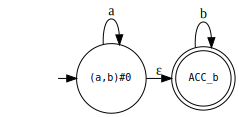

In [431]:
root, nodes, interfaces = build_tree(G3, 'a', 'b')
nfa = build_enfa_from_tree(G3, root, nodes, interfaces)
#print(nfa.accepts_input('abcbcbcccb'))  # quick membership test
draw_nfa(nfa)



Loop that grows the interface until saturation

In [432]:
from collections import defaultdict, deque
from copy import deepcopy
from typing import Dict, Tuple, Set, FrozenSet

# --------------------------------------------------------------
# Helper: pretty "(a,b)"  and counter-based unique names
# --------------------------------------------------------------
from collections import defaultdict

def pretty_AB(A: FrozenSet[str], B: FrozenSet[str]) -> str:
    a = ",".join(sorted(A)) or "∅"
    b = ",".join(sorted(B)) or "∅"
    return f"({a},{b})"

# per-label counters
_label_counter: defaultdict[Tuple[FrozenSet, FrozenSet], int] = defaultdict(int)

def unique_state_name(node: TreeNode) -> str:
    lbl = (node.A, node.B)
    _label_counter[lbl] += 1
    k = _label_counter[lbl]
    return f"{pretty_AB(node.A, node.B)}_{k}"

# ───────────────────────── helper to scan one NFA ───────────────────────
def scan_nfa_for_new_interfaces(
    nfa: NFA,
    G: Grammar,
    nodes: list[TreeNode],
    interfaces: dict[tuple[FrozenSet[str], FrozenSet[str]], set[str]],
):
    add = defaultdict(set)

    label_of = {n.nfa_name: (n.A, n.B) for n in nodes}

    # ε-closures ---------------------------------------------------------
    eps = {}
    for s in nfa.states:
        cl, dq = {s}, deque([s])
        while dq:
            u = dq.popleft()
            for v in nfa.transitions[u].get("", []):
                if v not in cl:
                    cl.add(v); dq.append(v)
        eps[s] = cl

    step = lambda sym, S: {v2
        for q in S
        for v1 in nfa.transitions[q].get(sym, [])
        for v2 in eps[v1]}

    # rules 1 & 2 --------------------------------------------------------
    for rule in G.binary_rules():
        x, y = rule.lhs
        z, = rule.rhs

        for p in label_of:
            A, _ = label_of[p]

            Sx = step(x, eps[p])
            if not Sx: continue

            # rule 2
            for s in Sx:
                lbl_s = label_of.get(s)
                if lbl_s:
                    C, D = lbl_s
                    if y in interfaces.get(lbl_s, set()).union(D) and A!=D:
                        if z in A or z in D:            # <-- new guard
                             continue
                        add[(A, D)].add(z)

            # rule 1
            Sy = step(y, Sx)
            for t in Sy:
                lbl_t = label_of.get(t)           # skip acceptors
                if lbl_t:
                    C, _ = lbl_t
                    if A != C:
                        if z in A or z in C:           
                            continue
                        add[(A, C)].add(z)

    # rule 3 -------------------------------------------------------------
    for p in label_of:
        A, _ = label_of[p]
        for z in G.alphabet:
            Sz = step(z, eps[p])
            for t in Sz:
                lbl_t = label_of.get(t)
                if lbl_t:
                    C, D = lbl_t
                    if z not in A.union(C) and A != C:
                        add[(A, C)].add(z)

    # discard duplicates
    for k in list(add):
        add[k] -= interfaces.get(k, set())
        if not add[k]:
            del add[k]
    return add


# ---------------------------------------------------------------
#  Driver : iterate until no interface grows
# ---------------------------------------------------------------
def saturate_interfaces(G: Grammar, s1: str, s2: str, verbose=False, max_iter=100):

    interfaces: dict[Tuple[FrozenSet, FrozenSet], set[str]] = {}

    for it in range(1, max_iter + 1):
        root, nodes, interfaces = build_tree(G, s1, s2, interfaces)

        nfa   = build_enfa_from_tree(G, root, nodes, interfaces)
        delta = scan_nfa_for_new_interfaces(nfa, G, nodes, interfaces)

        if verbose:
            print(f"Iter {it}: +{sum(map(len,delta.values()))} letters, |I|={len(interfaces)}")
        if not delta:
            return interfaces, root, nodes, nfa

        # merge delta before next loop
        for k, v in delta.items():
            interfaces.setdefault(k, set()).update(v)

    raise RuntimeError("No convergence in max_iter")


In [447]:
#run the loop
interfaces, root, nodes, nfa = saturate_interfaces(G1, 'a', 'b', verbose=True)
#final automaton
#print(nfa.accepts_input('01←ab'))  # quick membership test
#show the final automaton
#draw_nfa(nfa, eps_symbol=EPS, rankdir="LR").view("final_nfa")
print(f"Final interfaces for {G3.name} with s1='0', s2='a':")
# print all non-empty interface, without frozenset
for (A, B), I in interfaces.items():
    if I:  # non-empty interface
        print(f"I({set(A)}, {set(B)}) = {I}")

Iter 1: +11 letters, |I|=6
Iter 2: +0 letters, |I|=7
Final interfaces for G3 with s1='0', s2='a':
I({'a'}, {'b'}) = {'d', 'c', 'f', 'g', 'e'}
I({'a'}, {'c'}) = {'e'}
I({'c'}, {'b'}) = {'d', 'a', 'f', 'g', 'e'}
I({'a'}, {'g'}) = {'c', 'e'}
I({'c'}, {'a'}) = {'e'}
I({'c'}, {'g'}) = {'a', 'e'}


In [448]:
#test membership
print("Membership tests:")
test_strings = [
    'ab',
    'acb',
    'abed',
    'abcb',
    'aaaf'
    
]
for test in test_strings:
    result = nfa.accepts_input(test)
    print(f"  {test:15} : {result}")

Membership tests:
  ab              : True
  acb             : True
  abed            : False
  abcb            : False
  aaaf            : True
